In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from fullfrlm import flow_refueling_location_model
from ema_workbench import IntegerParameter, RealParameter, Model, ScalarOutcome, ArrayOutcome, Constant
import time

In [ ]:
## Load necessary data
df_h = pickle.load(open("data/revised_cleaning_results/harbour_data_100.p", "rb"))
df_ivs = pickle.load(open("data/revised_cleaning_results/ivs_exploded_100.p", "rb"))
path_lengths = pickle.load(open("data/revised_cleaning_results/path_lengths_ship_specific_routes.p", "rb"))
G = pickle.load(open('data/network_cleaned_final.p', 'rb'))
paths = pickle.load(open("data/final_paths.p", "rb"))

In [ ]:
%%time
total_flow, fraction_captured_total, serveable_fraction, served_fraction, routes_supported, extra_nodes_used = flow_refueling_location_model(1, 100000, 100, 5, 5, 50)

In [ ]:
total_flow

In [ ]:
fraction_captured_total

In [ ]:
serveable_fraction

In [ ]:
served_fraction

In [ ]:
routes_supported

In [ ]:
extra_nodes_used

## Works, now connect to workbench

In [ ]:
#define model
model = Model("frlm", function=flow_refueling_location_model)

In [ ]:
#define parameters

model.constants = [
    Constant("station_cap", 5),
    Constant("max_per_loc", 5),
]

model.uncertainties = [
    RealParameter("load", 0.75, 1.25)
    IntegerParameter("r", 40000, 200000),
]

# set levers
model.levers = [
    IntegerParameter("stations_to_place", 10, 300),
    IntegerParameter("additional_nodes", 0, 50)
]

# specify outcomes
model.outcomes = [
    ScalarOutcome("total_flow"),
    ScalarOutcome("supported_fraction"),
    ScalarOutcome("routes_supported"),
    ScalarOutcome("extra_nodes_used"),
]

model.constants = [
    Constant("station_cap", 5),
    Constant("max_per_loc", 5),
]
# model.constants = [
#     Constant("station_cap", 5),
#     Constant("max_per_loc", 5),
# ]

# model.uncertainties = [
#     RealParameter("load", 0.75, 1.25, (0.75, 1.25)),
#     IntegerParameter("r", 40000, 200000, (40000, 200000)),
# ]

# # set levers
# model.levers = [
#     IntegerParameter("stations_to_place", 10, 300, (10, 100)),
#     IntegerParameter("additional_nodes", 0, 50, (0, 30))
# ]

# # specify outcomes
# model.outcomes = [
#     ScalarOutcome("total_flow"),
#     ScalarOutcome("supported_fraction"),
#     ScalarOutcome("routes_supported"),
#     ScalarOutcome("extra_nodes_used"),
# ]

# model.constants = [
#     Constant("station_cap", 5),
#     Constant("max_per_loc", 5),
# ]

In [ ]:
IntegerParameter?

In [ ]:
from ema_workbench import MultiprocessingEvaluator, SequentialEvaluator, ema_logging, perform_experiments

ema_logging.log_to_stderr(ema_logging.INFO)

with SequentialEvaluator(model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=2, policies=2)

In [ ]:
pickle.dump( experiments, open( "results/experiments_15s_42.p", "wb" ) )
pickle.dump( outcomes, open("results/outcomes_15s_42.p", "wb") )
# experiments = pickle.load( open("results/experiments_300s_10.p", "rb"))
# outcomes = pickle.load( open("results/outcomes_300s_10.p", "rb"))

## Run model for 300 and 10 policies without changing station cap and max per loc

In [ ]:
experiments

In [ ]:
from ema_workbench import MultiprocessingEvaluator, SequentialEvaluator, ema_logging, perform_experiments
from ema_workbench import IntegerParameter, RealParameter, Model, ScalarOutcome, ArrayOutcome, Constant
ema_logging.log_to_stderr(ema_logging.INFO)

model = Model("frlm", function=flow_refueling_location_model)


In [ ]:

# specify uncertainties
model.uncertainties = [
    RealParameter("load", 0.75, 1.25),
    IntegerParameter("r", 50000, 250000),
]

# set levers
model.levers = [
    IntegerParameter("stations_to_place", 1, 350),
    IntegerParameter("station_cap", 1, 5),
    IntegerParameter("max_per_loc", 1, 5)
]

# specify outcomes
model.outcomes = [
    ScalarOutcome("total_flow"),
    ScalarOutcome("supported_fraction"),
]

# model.constants = [
#     Constant("station_cap", 5),
#     Constant("max_per_loc", 5),
# ]

In [ ]:
# pickle.dump( experiments, open( "results/experiments_300s_20.p", "wb" ) )
# pickle.dump( outcomes, open("results/outcomes_300s_20.p", "wb") )

## Visualize results for each policy in a pairplot

In [ ]:
policies = experiments["policy"]
for i, policy in enumerate(np.unique(policies)):
    experiments.loc[policies == policy, "policy"] = str(i)

data = pd.DataFrame(outcomes)
data["policy"] = policies

In [ ]:
sns.pairplot(data, hue="policy", vars=list(outcomes.keys()))
plt.show()

## "Normal" pairplot?

In [ ]:
all_data = experiments.copy()
all_data['total_flow'] = outcomes['total_flow']
all_data['supported_fraction'] = outcomes['supported_fraction']
all_data['routes_supported'] = outcomes['routes_supported']
all_data['extra_nodes_used'] = outcomes['extra_nodes_used']

In [ ]:
all_data

In [ ]:
# all_data = all_data.loc[:, ['load','r', 'stations_to_place','total_flow','supported_fraction']]

In [ ]:
sns.pairplot(all_data, vars=list(outcomes.keys()))

In [ ]:
sns.pairplot(all_data)

In [10]:
all_data

,load,r,additional_nodes,stations_to_place,scenario,policy,model,total_flow,supported_fraction,routes_supported,extra_nodes_used
0,1.033713,154484.0,21.0,215.0,4,0,frlm,1299.221370,0.403833,66.0,10.0
1,0.913505,59401.0,21.0,215.0,5,0,frlm,1152.131742,0.209634,32.0,3.0
2,1.196304,176424.0,21.0,215.0,6,0,frlm,1506.011585,0.406135,66.0,11.0
3,0.806994,104827.0,21.0,215.0,7,0,frlm,1016.916164,0.341347,58.0,5.0
4,1.033713,154484.0,0.0,133.0,4,1,frlm,1304.643992,0.355655,76.0,0.0
5,0.913505,59401.0,0.0,133.0,5,1,frlm,1147.843366,0.200858,32.0,0.0
6,1.196304,176424.0,0.0,133.0,6,1,frlm,1509.172994,0.357467,73.0,0.0
7,0.806994,104827.0,0.0,133.0,7,1,frlm,1015.461996,0.309784,57.0,0.0
8,1.033713,154484.0,26.0,232.0,4,2,frlm,1301.642114,0.402719,67.0,12.0
9,0.913505,59401.0,26.0,232.0,5,2,frlm,1146.572994,0.210707,36.0,7.0


In [ ]:
# all_data = all_data.loc[:, ['load','r', 'stations_to_place','total_flow','supported_fraction']]

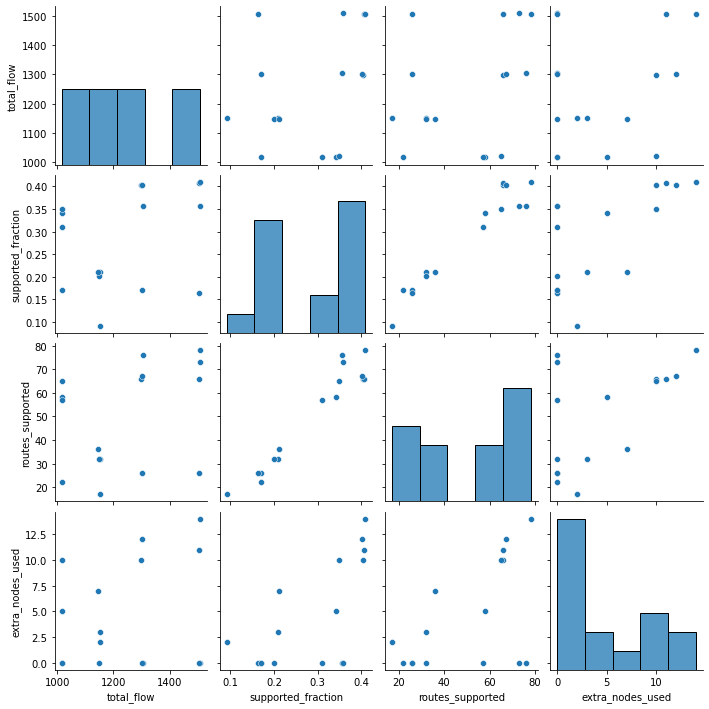

In [11]:
sns.pairplot(all_data, vars=list(outcomes.keys()))

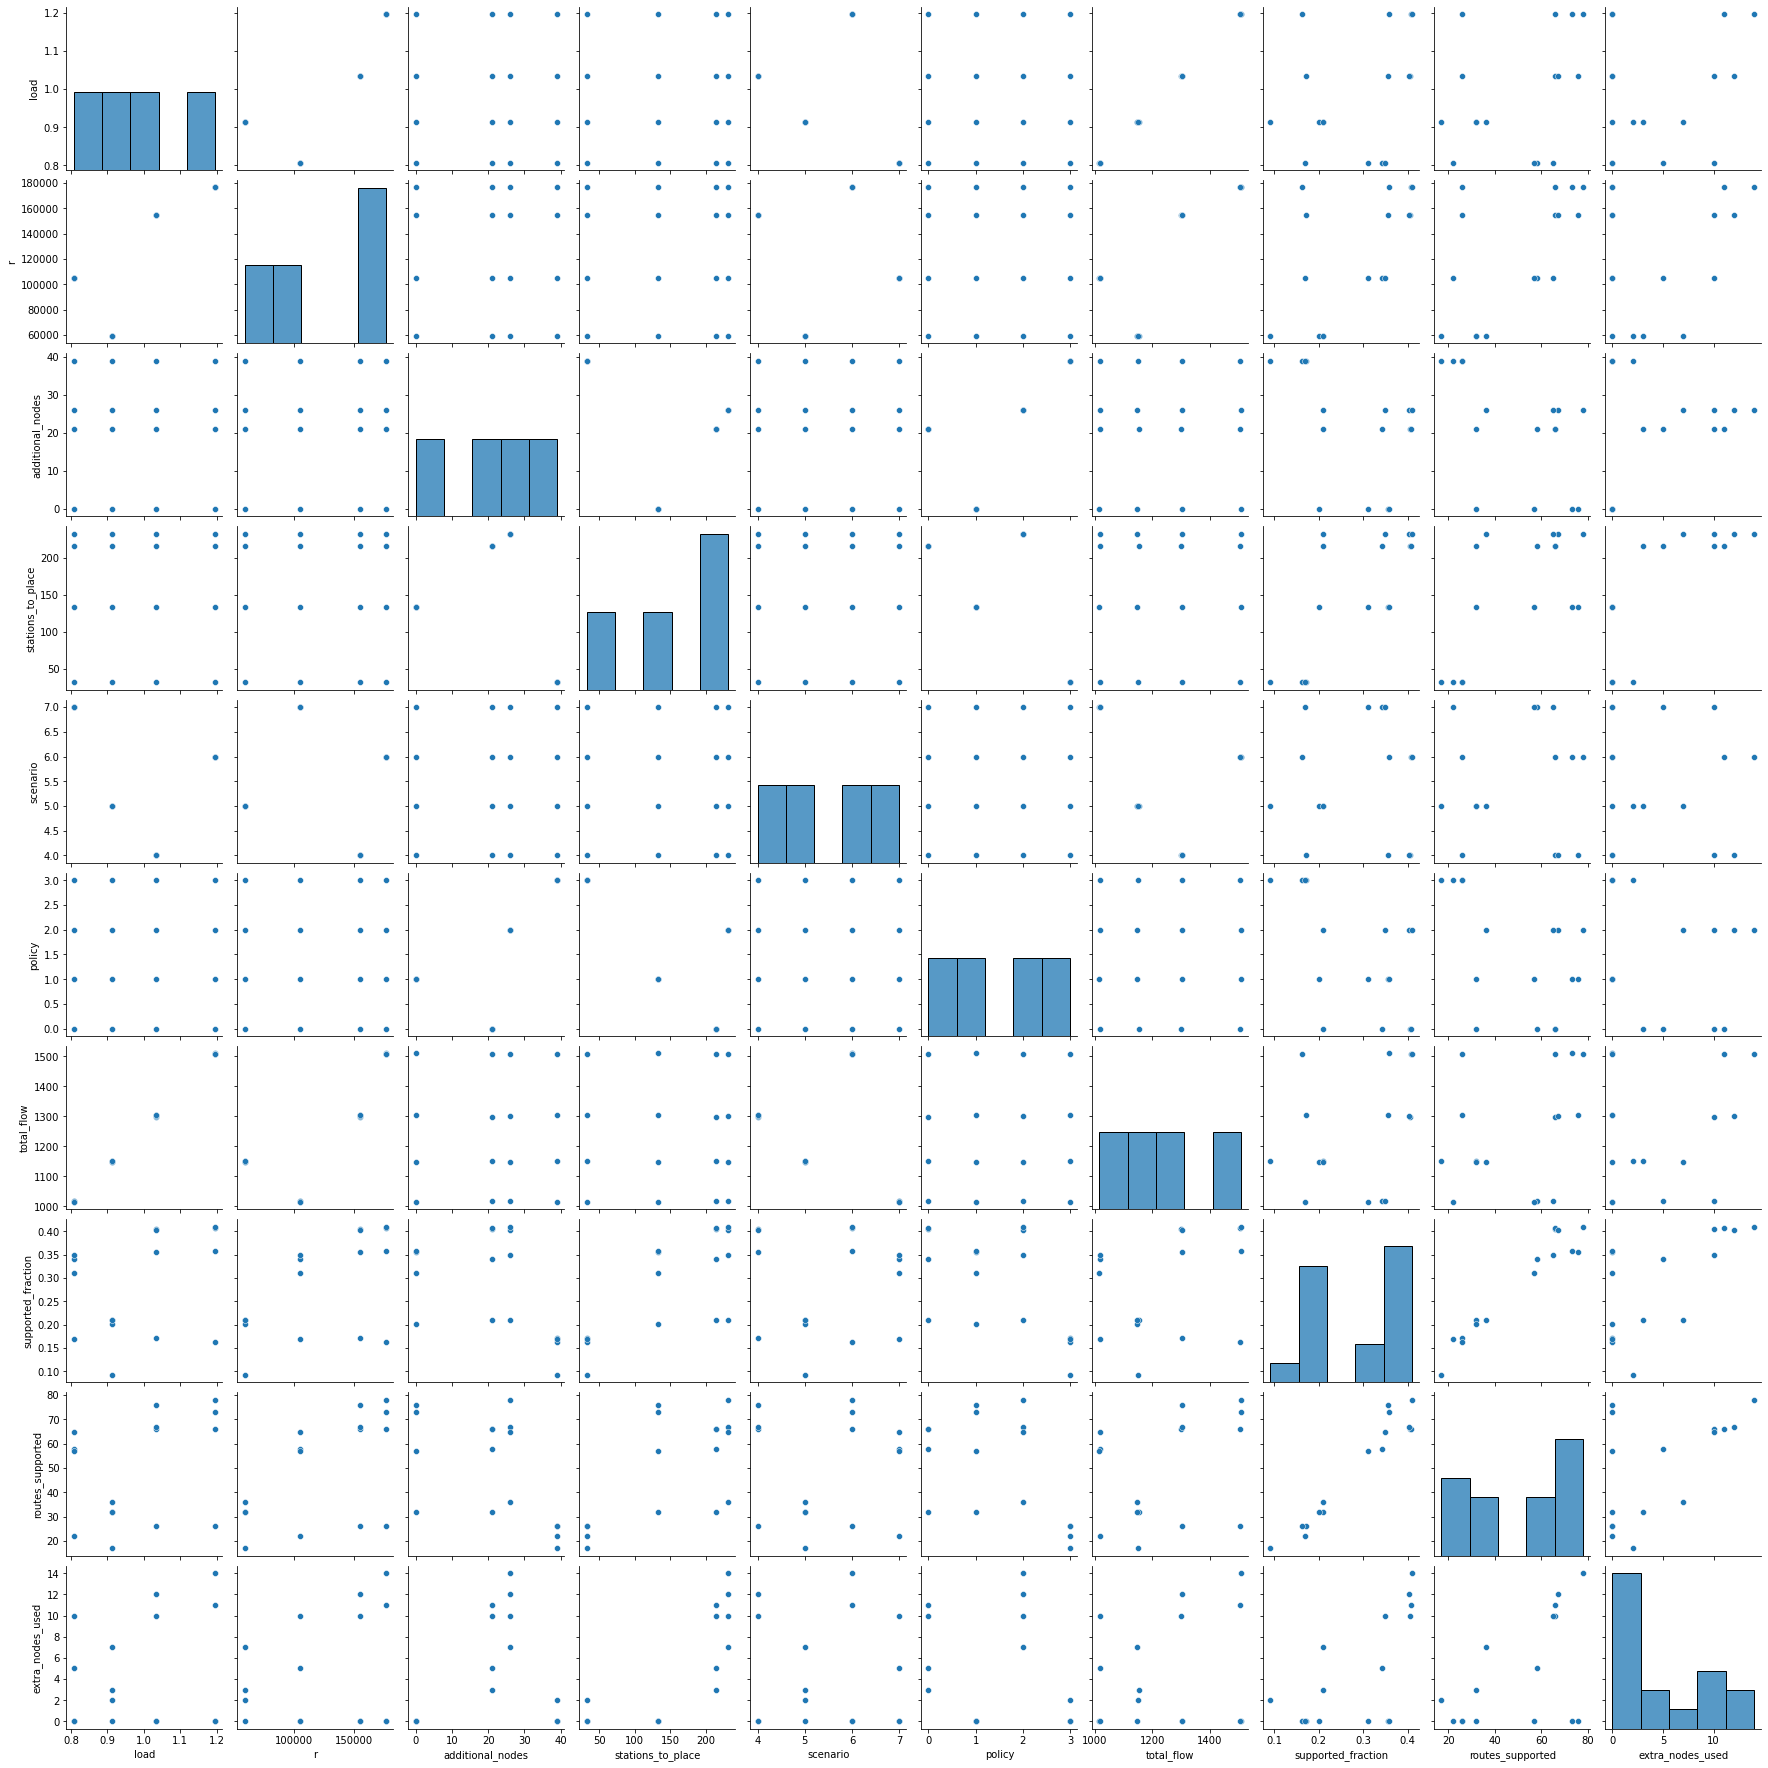

In [12]:
sns.pairplot(all_data)

## Visualize how results are correlated

[MainProcess/INFO] no time dimension found in results


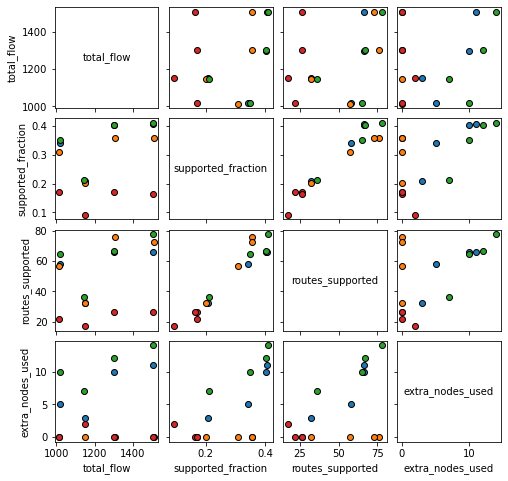

In [ ]:
from ema_workbench.analysis import pairs_plotting

fig, axes = pairs_plotting.pairs_scatter(
    experiments, outcomes, group_by="policy", legend=False
)
fig.set_size_inches(8, 8)
plt.show()

In [ ]:
from ema_workbench.analysis import prim
%matplotlib inline
x = experiments
y = (1-outcomes["supported_fraction"]) < 0.8
prim_alg = prim.Prim(x, y, threshold=0.8)
box1 = prim_alg.find_box()

In [ ]:
box1.show_tradeoff()
plt.show()

In [ ]:
box1.inspect(10)
box1.inspect(10, style="graph")
plt.show()

In [ ]:
box1.show_pairs_scatter(10)
plt.show()

In [ ]:
from ema_workbench.analysis import feature_scoring

x = experiments
y = outcomes

fs = feature_scoring.get_feature_scores_all(x, y)
sns.heatmap(fs, cmap="viridis", annot=True)
plt.show()

In [ ]:
from ema_workbench.analysis import dimensional_stacking

x = experiments
y = (1-outcomes["supported_fraction"]) < 0.8
dimensional_stacking.create_pivot_plot(x, y, 2, nbins=3)
plt.show()

In [ ]:
from ema_workbench.analysis import regional_sa
from numpy.lib import recfunctions as rf

sns.set_style("white")

# model is the same across experiments
x = experiments.copy()
x = x.drop("model", axis=1)
y = (1-outcomes["supported_fraction"]) < 0.8
fig = regional_sa.plot_cdfs(x, y)
sns.despine()
plt.show()

In [ ]:
from ema_workbench.analysis import regional_sa
from numpy.lib import recfunctions as rf

sns.set_style("white")

# model is the same across experiments
x = experiments.copy()
x = x.drop("model", axis=1)
y = (outcomes["total_flow"]) < 1000
fig = regional_sa.plot_cdfs(x, y)
sns.despine()
plt.show()

## Sobol sampling

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from fullfrlm import flow_refueling_location_model

## Load necessary data
G = pickle.load(open('data/cleaned_network.p', 'rb'))
df_h = pickle.load(open("data/harbour_data_100.p", "rb"))
df_ivs = pickle.load(open("data/ivs_exploded_100.p", "rb"))
paths = pickle.load(open("data/paths_ship_specific_routes.p", "rb"))
path_lengths = pickle.load(open("data/path_lengths_ship_specific_routes.p", "rb"))

In [ ]:
from ema_workbench import MultiprocessingEvaluator, SequentialEvaluator
from SALib.analyze import sobol
from ema_workbench import Samplers, Model
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

model = Model("frlm", function=flow_refueling_location_model)

In [ ]:
from ema_workbench import IntegerParameter, RealParameter, Model, ScalarOutcome, ArrayOutcome

model = Model("frlm", function=flow_refueling_location_model)
#

# specify uncertainties
model.uncertainties = [
    RealParameter("load", 0, 1),
    IntegerParameter("r", 50000, 200000),
    IntegerParameter("stations_to_place", 1, 350),
    IntegerParameter("station_cap", 1, 5),
    IntegerParameter("max_per_loc", 1, 5)
]

# set levers
# model.levers = [
#     IntegerParameter("stations_to_place", 1, 350),
#     IntegerParameter("station_cap", 1, 5),
#     IntegerParameter("max_per_loc", 1, 5),
# ]

# specify outcomes
model.outcomes = [
    ScalarOutcome("total_flow"),
    ScalarOutcome("supported_fraction"),
]

In [ ]:
with MultiprocessingEvaluator(model) as evaluator:
    sa_results = evaluator.perform_experiments(scenarios=1000, uncertainty_sampling=Samplers.SOBOL)

In [ ]:
pickle.dump( sa_results, open( "results/sa_1000.p", "wb" ) )

In [ ]:

experiments, outcomes = sa_results

problem = get_SALib_problem(model.uncertainties)
Si = sobol.analyze(
    problem, outcomes["supported_fraction"], calc_second_order=True, print_to_console=False
)